In [12]:
# importing the required module 
import matplotlib.pyplot as plt 
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pydicom import dcmread
from pydicom.data import get_testdata_file
import os
import cv2
import shutil
import pydicom as dicom
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import glob
import re

In [3]:
#main_directory = '/home/kiara/Desktop/LV_CMRI/MICCAI_RV/'
main_directory = '/home/kiara/Desktop/LV_CMRI/RV_test/'

In [6]:
# find all images with i and o contours
# list of all .txt files in MICCAI_RV directory
txt_list = []
patient_list = []
for file in os.listdir(main_directory):
    if file.endswith("manual.txt"):
        txt_list.append(file)
    if file.endswith("list.txt"):
        patient_list.append(file)  
        
print(len(patient_list))
print(patient_list)
print(len(txt_list))
print(txt_list)

16
['P06list.txt', 'P01list.txt', 'P09list.txt', 'P12list.txt', 'P02list.txt', 'P14list.txt', 'P13list.txt', 'P07list.txt', 'P10list.txt', 'P16list.txt', 'P04list.txt', 'P08list.txt', 'P15list.txt', 'P03list.txt', 'P05list.txt', 'P11list.txt']
486
['P03-0100-ocontour-manual.txt', 'P11-0127-ocontour-manual.txt', 'P08-0120-ocontour-manual.txt', 'P12-0108-ocontour-manual.txt', 'P06-0080-ocontour-manual.txt', 'P14-0120-icontour-manual.txt', 'P05-0110-icontour-manual.txt', 'P14-0108-icontour-manual.txt', 'P02-0148-ocontour-manual.txt', 'P05-0200-ocontour-manual.txt', 'P06-0148-ocontour-manual.txt', 'P03-0060-ocontour-manual.txt', 'P04-0080-icontour-manual.txt', 'P03-0100-icontour-manual.txt', 'P06-0120-ocontour-manual.txt', 'P14-0040-icontour-manual.txt', 'P04-0060-ocontour-manual.txt', 'P15-0060-ocontour-manual.txt', 'P02-0108-icontour-manual.txt', 'P16-0040-icontour-manual.txt', 'P07-0107-ocontour-manual.txt', 'P08-0180-icontour-manual.txt', 'P13-0106-icontour-manual.txt', 'P03-0120-ocont

In [25]:
# loop through .txt file containing epicardium (or endocardium) contours, line by line and extract x, y values
def get_coordinates(file_location):
    f = open(file_location, "r")
    x_values = []
    y_values = []
    for xy in f:
        x_and_y = xy.split()
        x_values.append(x_and_y[0])
        y_values.append(x_and_y[1])
    # converting the list of strings to list of integers
    x_values = list(map(float, x_values))
    y_values = list(map(float, y_values))
    return x_values, y_values

In [30]:
# obtaining the label image and saving it in specific location
def get_label_image(x_ocoordinates, y_ocoordinates, x_icoordinates, y_icoordinates, fig_name):
    # plotting the points
    ax = plt.axes()
    # set background blue
    ax.set_facecolor((0,0,1))
    plt.fill(x_ocoordinates, y_ocoordinates, color = (0,1,0))
    plt.fill(x_icoordinates, y_icoordinates, color = (1,0,0))
    # Display a figure and save it
    plt.savefig(fig_name+'.png', format='png', dpi=50)
    plt.show()

In [34]:
train_img_fnames = []

['P16-0040-icontour-manual.txt', 'P16-0040-ocontour-manual.txt', 'P16-0060-icontour-manual.txt', 'P16-0060-ocontour-manual.txt', 'P16-0067-icontour-manual.txt', 'P16-0067-ocontour-manual.txt', 'P16-0080-icontour-manual.txt', 'P16-0080-ocontour-manual.txt', 'P16-0087-icontour-manual.txt', 'P16-0087-ocontour-manual.txt', 'P16-0100-icontour-manual.txt', 'P16-0100-ocontour-manual.txt', 'P16-0107-icontour-manual.txt', 'P16-0107-ocontour-manual.txt', 'P16-0120-icontour-manual.txt', 'P16-0120-ocontour-manual.txt', 'P16-0127-icontour-manual.txt', 'P16-0127-ocontour-manual.txt', 'P16-0140-icontour-manual.txt', 'P16-0140-ocontour-manual.txt', 'P16-0147-icontour-manual.txt', 'P16-0147-ocontour-manual.txt', 'P16-0160-icontour-manual.txt', 'P16-0160-ocontour-manual.txt', 'P16-0167-icontour-manual.txt', 'P16-0167-ocontour-manual.txt', 'P16-0180-icontour-manual.txt', 'P16-0180-ocontour-manual.txt', 'P16-0187-icontour-manual.txt', 'P16-0187-ocontour-manual.txt', 'P16-0200-icontour-manual.txt', 'P16-02

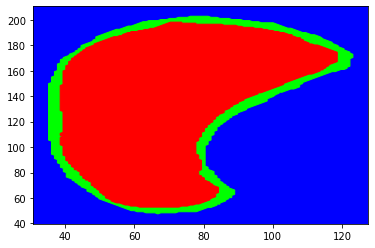

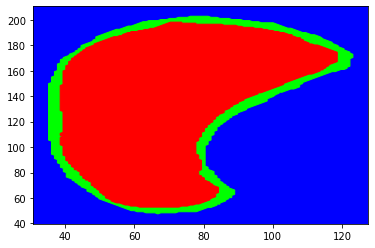

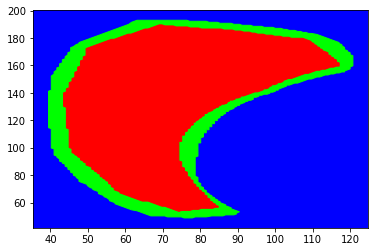

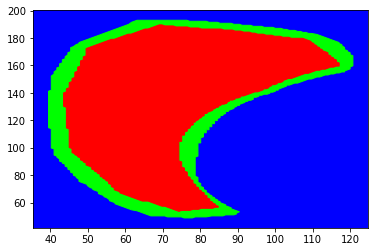

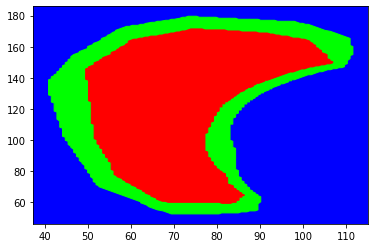

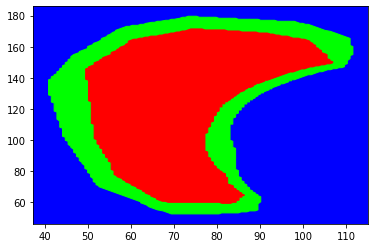

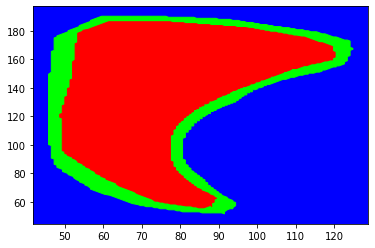

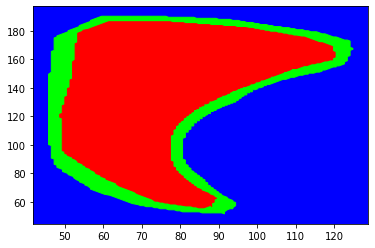

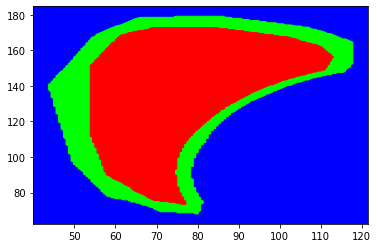

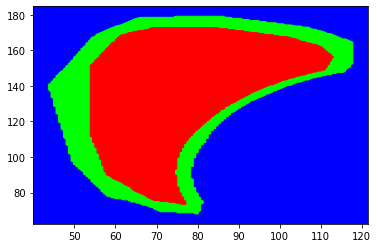

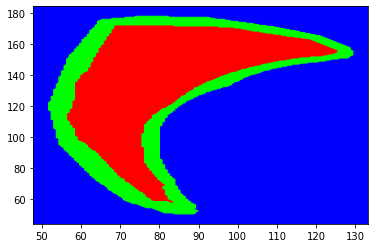

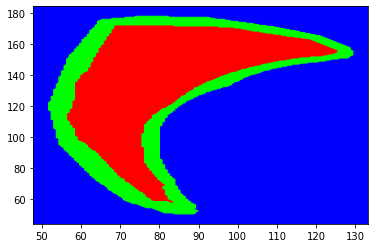

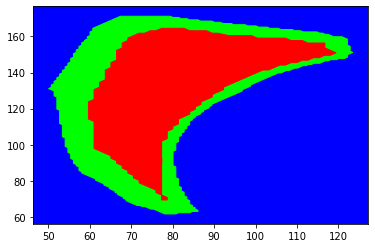

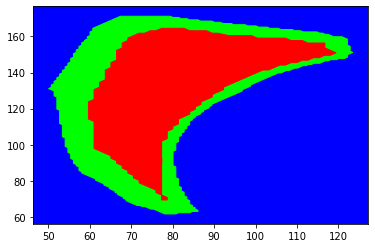

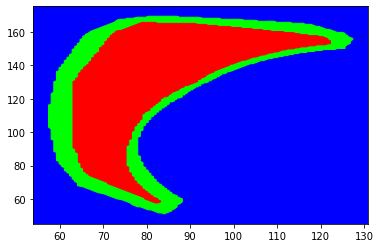

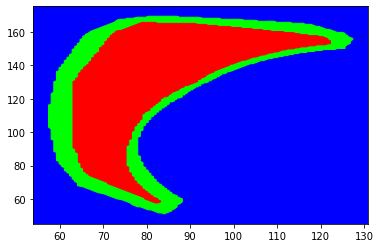

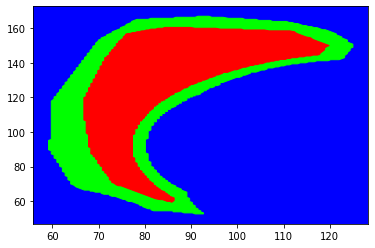

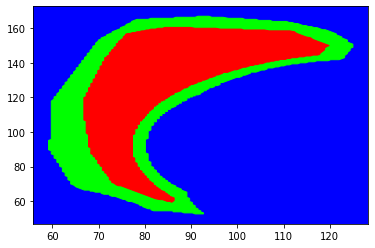

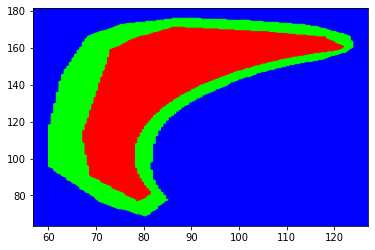

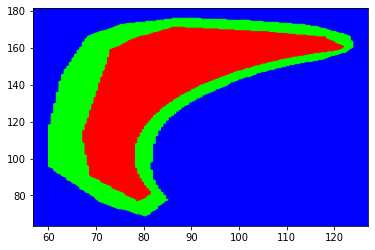

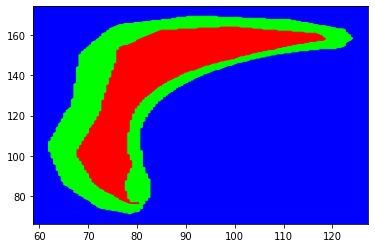

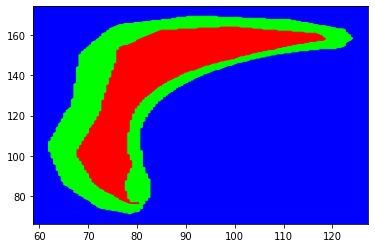

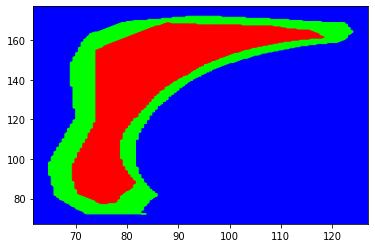

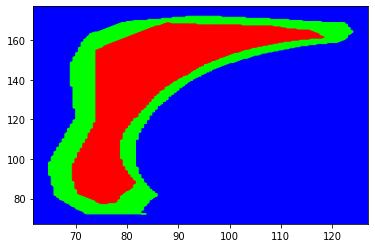

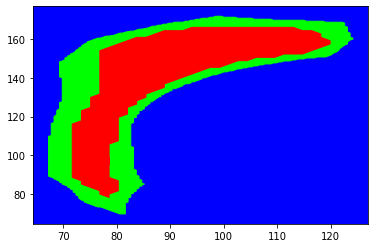

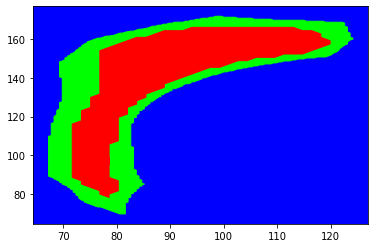

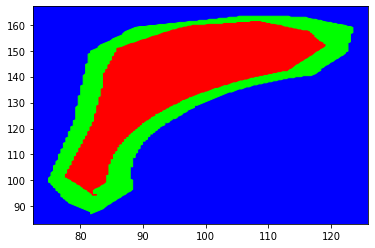

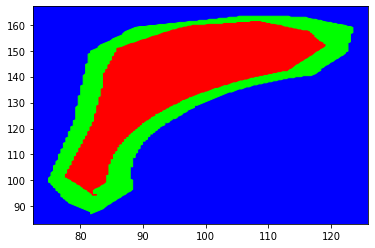

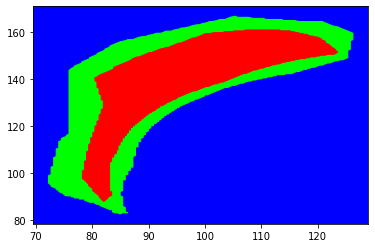

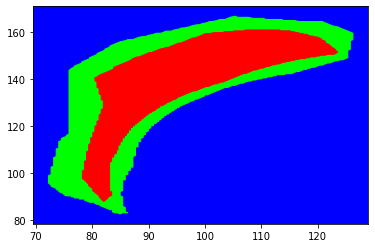

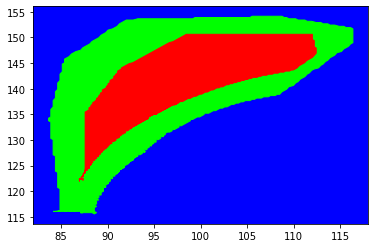

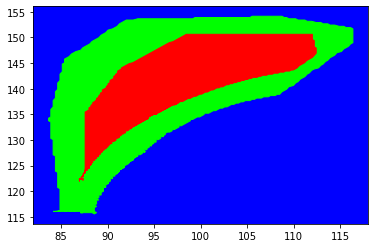

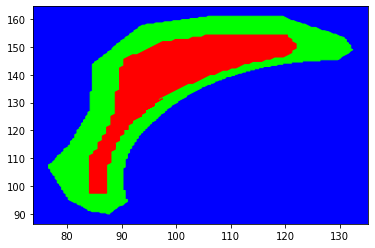

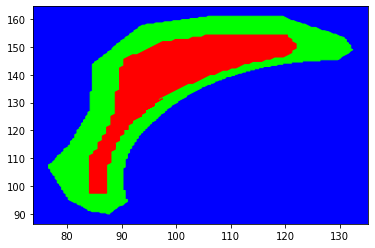

In [53]:
patients = ['P01list.txt', 'P02list.txt', 'P03list.txt', 'P04list.txt', 'P05list.txt', 'P06list.txt', 'P07list.txt', 'P08list.txt', 'P09list.txt', 'P10list.txt', 'P11list.txt', 'P12list.txt', 'P13list.txt', 'P14list.txt', 'P15list.txt', 'P16list.txt']

def patients_to_labelimg(p):
    # open file for patient i
    textfile = open(main_directory + p)
    lines = textfile.readlines()
    # remove unwanted characters from each item in list
    edited_lines = [re.compile(r".\\patient16\\").sub("", m) for m in lines] # change manually
    edited_lines = [re.compile(r'P16contours-manual\\').sub("", m) for m in edited_lines] # change manually
    edited_lines = [re.compile(r'\n').sub("", m) for m in edited_lines]
    #edited_lines = map(lambda each:each.strip(".\\patient01\\"), lines)
    print(edited_lines)
    
    # image names for which i and o contours are available
    # get image list
    images_list = []
    for f in edited_lines:
        image_name = f[0:8] + '.dcm'
        images_list.append(image_name)
        
        # obtaining corresponding i and o contour
        i_contour = f[0:8] + '-icontour-manual.txt'
        o_contour = f[0:8] + '-ocontour-manual.txt'
        
        # reading i_contour and o_contour .txt files and obtaining coordinates
        x_icoordinates, y_icoordinates = get_coordinates(main_directory + i_contour)
        x_ocoordinates, y_ocoordinates = get_coordinates(main_directory + o_contour)

        # plot the coordinates obtained and save
        fig_name = f[0:8]
        get_label_image(x_ocoordinates, y_ocoordinates, x_icoordinates, y_icoordinates, fig_name)
        
        
    return images_list

        
        
train_img_fnames = train_img_fnames + patients_to_labelimg(patients[15])

In [56]:
# defining the training image and label(mask) directories
train_label_dir = os.path.join(main_directory, 'RV_Label/')
train_label_fname = os.listdir(train_label_dir)
#print(train_label_fname)
#train_label_dir = os.path.join(base_dir, 'SCCOR_labels/ShortAxis')

['P01-0108.png', 'P02-0168.png', 'P06-0128.png', 'P16-0160.png', 'P12-0100.png', 'P14-0100.png', 'P07-0200.png', 'P06-0148.png', 'P10-0020.png', 'P03-0088.png', 'P12-0148.png', 'P14-0040.png', 'P13-0060.png', 'P08-0188.png', 'P13-0160.png', 'P13-0106.png', 'P15-0120.png', 'P04-0200.png', 'P01-0240.png', 'P14-0180.png', 'P10-0187.png', 'P15-0080.png', 'P10-0087.png', 'P13-0200.png', 'P07-0140.png', 'P08-0148.png', 'P13-0040.png', 'P08-0128.png', 'P04-0040.png', 'P07-0080.png', 'P01-0100.png', 'P16-0167.png', 'P09-0160.png', 'P03-0080.png', 'P09-0120.png', 'P04-0108.png', 'P02-0080.png', 'P14-0120.png', 'P13-0066.png', 'P12-0168.png', 'P09-0127.png', 'P15-0160.png', 'P01-0220.png', 'P12-0188.png', 'P14-0148.png', 'P02-0120.png', 'P03-0120.png', 'P16-0200.png', 'P07-0187.png', 'P16-0140.png', 'P11-0160.png', 'P15-0168.png', 'P13-0080.png', 'P15-0140.png', 'P10-0167.png', 'P07-0167.png', 'P09-0187.png', 'P11-0087.png', 'P14-0188.png', 'P03-0140.png', 'P09-0167.png', 'P01-0188.png', 'P16-01

In [67]:
train_img_fname = []
for item in train_label_fname:
    h = item.replace('.png', '.dcm')
    train_img_fname.append(h)
print(train_img_fname)

['P01-0108.dcm', 'P02-0168.dcm', 'P06-0128.dcm', 'P16-0160.dcm', 'P12-0100.dcm', 'P14-0100.dcm', 'P07-0200.dcm', 'P06-0148.dcm', 'P10-0020.dcm', 'P03-0088.dcm', 'P12-0148.dcm', 'P14-0040.dcm', 'P13-0060.dcm', 'P08-0188.dcm', 'P13-0160.dcm', 'P13-0106.dcm', 'P15-0120.dcm', 'P04-0200.dcm', 'P01-0240.dcm', 'P14-0180.dcm', 'P10-0187.dcm', 'P15-0080.dcm', 'P10-0087.dcm', 'P13-0200.dcm', 'P07-0140.dcm', 'P08-0148.dcm', 'P13-0040.dcm', 'P08-0128.dcm', 'P04-0040.dcm', 'P07-0080.dcm', 'P01-0100.dcm', 'P16-0167.dcm', 'P09-0160.dcm', 'P03-0080.dcm', 'P09-0120.dcm', 'P04-0108.dcm', 'P02-0080.dcm', 'P14-0120.dcm', 'P13-0066.dcm', 'P12-0168.dcm', 'P09-0127.dcm', 'P15-0160.dcm', 'P01-0220.dcm', 'P12-0188.dcm', 'P14-0148.dcm', 'P02-0120.dcm', 'P03-0120.dcm', 'P16-0200.dcm', 'P07-0187.dcm', 'P16-0140.dcm', 'P11-0160.dcm', 'P15-0168.dcm', 'P13-0080.dcm', 'P15-0140.dcm', 'P10-0167.dcm', 'P07-0167.dcm', 'P09-0187.dcm', 'P11-0087.dcm', 'P14-0188.dcm', 'P03-0140.dcm', 'P09-0167.dcm', 'P01-0188.dcm', 'P16-01

In [69]:
import shutil
import os

source =  '/home/kiara/Desktop/LV_CMRI/MICCAI_RV/All'
dest = main_directory + 'RV_Images'

for file in train_img_fname:
    shutil.move(os.path.join(source, file), dest)